In [21]:
import os 
import sys
# Ajouter le chemin du répertoire parent de cifar10_classification
project_path = os.path.abspath('..')
if project_path not in sys.path:
    sys.path.append(project_path)
print(project_path)

/home/mkbrad7/afs_epita/ING2/ML_reconnaissance_de_forme/Projet/classifiaction_cifar


In [22]:
import numpy as np
import joblib
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from cifar10_classification.plots import plot_confusion_matrix, plot_roc_curve
from cifar10_classification.dataset import prepare_data
from cifar10_classification.features import extract_features
from cifar10_classification.modeling.predict import predict_model
from cifar10_classification.config import LABEL_NAMES, NUM_CLASSES, DATA_DIR, MODEL_DIR


In [23]:
# Chemins vers les modèles sauvegardés
MODEL_PATHS = {
    'logistic_hog': MODEL_DIR + '/logistic_hog_best_model.pkl',
    'logistic_sift': MODEL_DIR + '/logistic_sift_best_model.pkl',
    'logistic_flatten': MODEL_DIR + '/logistic_flatten_best_model.pkl',
    'random_forest_flatten': MODEL_DIR + '/random_forest_flatten_best_model.pkl',
    'random_forest_sift': MODEL_DIR + '/random_forest_sift_best_model.pkl',
    'random_forest_hog': MODEL_DIR + '/random_forest_hog_best_model.pkl',
    'svm_hog': MODEL_DIR + '/svm_hog_best_model.pkl'
}

In [24]:
# Charger les données
X_train, y_train, X_val, y_val, X_test, y_test = prepare_data()
# Fonction pour charger un modèle
def load_model(path):
    model = joblib.load(path)
    return model

# Charger les modèles
models = {name: load_model(path) for name, path in MODEL_PATHS.items()}
import pandas as pd


/home/mkbrad7/anaconda3/lib/python3.11/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/mkbrad7/anaconda3/lib/python3.11/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.5.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/mkbrad7/anaconda3/lib/python3.11/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.5.0 when using version 1.3.0. This

In [25]:
params_list = []
for name, model in models.items():
    if hasattr(model.named_steps[model.steps[-1][0]], 'best_params_'):
        best_params = model.named_steps[model.steps[-1][0]].best_params_
    else:
        best_params = model.named_steps[model.steps[-1][0]].get_params()

    # Ajouter le nom du modèle uniquement pour la première ligne
    params_list.append({'model': name, 'param': list(best_params.keys())[0], 'value': list(best_params.values())[0]})
    
    # Ajouter les paramètres suivants sans répéter le nom du modèle
    for param, value in list(best_params.items())[1:]:
        params_list.append({'model': '', 'param': param, 'value': value})

# Stoquer ces hyperparamètres dans un dataframe
df = pd.DataFrame(params_list)
df.to_csv(MODEL_DIR + '/models_hyperparameters.csv', index=False)
df

,model,param,value
0,logistic_hog,C,0.1
1,,class_weight,None
2,,dual,False
3,,fit_intercept,True
4,,intercept_scaling,1
...,...,...,...
109,,probability,False
110,,random_state,None
111,,shrinking,True
112,,tol,0.001


In [26]:
features = {
    'flatten': extract_features(X_test, method='flatten'),
    'hog': extract_features(X_test, method='hog'),
    'sift': extract_features(X_test, method='sift')
}

/home/mkbrad7/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [27]:
# features = {
#     'flatten': extract_features(X_val, method='flatten'),
#     'hog': extract_features(X_val, method='hog'),
#     'sift': extract_features(X_val, method='sift')
# }

In [28]:
predictions = {}
for model_name, model in models.items():
    method = model_name.split('_')[-1]
    print(f"Predicting with {model_name}...")
    if method == 'sift':
        try:
            X_test_features = features[method]
            y_pred = model.predict(X_test_features)
        except:
            X_test_features = np.hstack((features[method], np.zeros((features[method].shape[0], 78))))
            y_pred = model.predict(X_test_features)
        # X has 50 features, but StandardScaler is expecting 128 features as input.
        # We need to add 78 zero columns to X to match the dimensionality.
    else:
        X_test_features = features[method]
        y_pred = model.predict(X_test_features)
    # y_pred = model.predict(X_val_features)
    y_score = model.predict_proba(X_test_features) if hasattr(model, "predict_proba") else model.decision_function(X_test_features)
    predictions[model_name] = (y_pred, y_score)

Predicting with logistic_hog...
Predicting with logistic_sift...
Predicting with logistic_flatten...
Predicting with random_forest_flatten...
Predicting with random_forest_sift...
Predicting with random_forest_hog...
Predicting with svm_hog...


In [29]:
# predictions = {}
# for model_name, model in models.items():
#     method = model_name.split('_')[-1]
#     print(f"Predicting with {model_name}...")
#     if method == 'sift':
#         try:
#             X_val_features = features[method]
#             y_pred = model.predict(X_val_features)
#         except:
#             X_val_features = np.hstack((features[method], np.zeros((features[method].shape[0], 78))))
#             y_pred = model.predict(X_val_features)
#         # X has 50 features, but StandardScaler is expecting 128 features as input.
#         # We need to add 78 zero columns to X to match the dimensionality.
#     else:
#         X_val_features = features[method]
#         y_pred = model.predict(X_val_features)
#     # y_pred = model.predict(X_val_features)
#     y_score = model.predict_proba(X_val_features) if hasattr(model, "predict_proba") else model.decision_function(X_val_features)
#     predictions[model_name] = (y_pred, y_score)


Model: logistic_hog
Accuracy: 0.5042
Confusion matrix, without normalization
[[589  40  93   8  42   7  26  17 155  23]
 [ 41 604  20  16  29   8  58  21  90 113]
 [ 82  25 383  67  93 124 107  56  44  19]
 [ 46  51  79 274 107 159 131  77  28  48]
 [ 38  31  61  70 431  72 123  94  34  46]
 [ 10  18  82 139  87 422 107  92  15  28]
 [ 20  46  50  54  88  61 633  20  18  10]
 [ 23  23  63  51 105  87  31 551  17  49]
 [162 113  30  17  16   7  20  16 525  94]
 [ 36 102  18  22  32  26  12  43  79 630]]


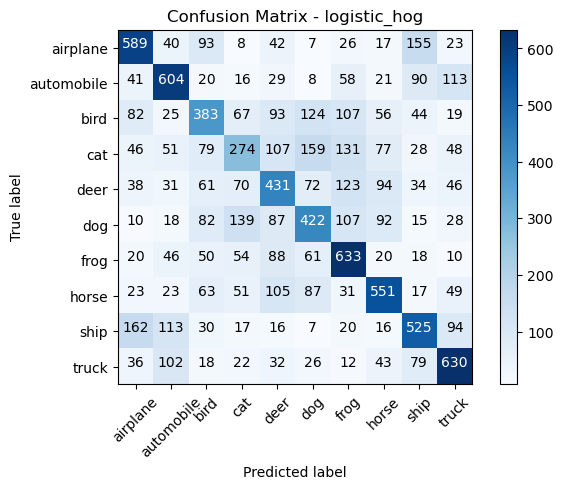

Model: logistic_sift
Accuracy: 0.1
Confusion matrix, without normalization
[[   0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]]


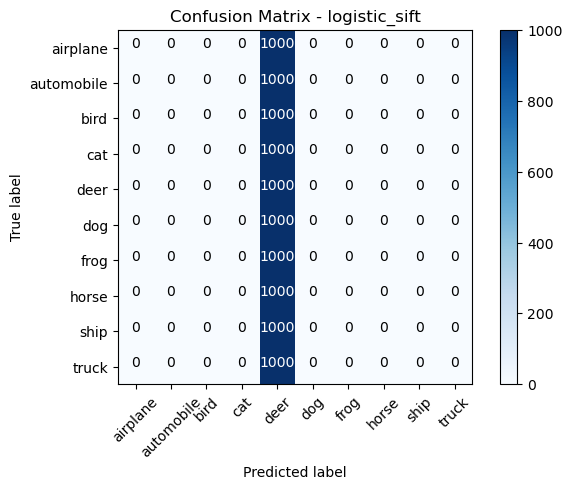

Model: logistic_flatten
Accuracy: 0.3957
Confusion matrix, without normalization
[[472  47  55  29  21  30  24  55 196  71]
 [ 63 500  25  39  24  43  38  40  77 151]
 [101  47 241  87 131  81 162  79  50  21]
 [ 45  68 100 260  56 183 134  49  38  67]
 [ 51  32 149  70 282  75 166 126  27  22]
 [ 43  54  92 157  71 341  88  83  48  23]
 [ 13  37  82 126 104  77 481  32  15  33]
 [ 43  43  58  55 109  78  60 422  44  88]
 [175  78  23  27  11  47  10  19 501 109]
 [ 70 183  21  28  16  24  44  56 101 457]]


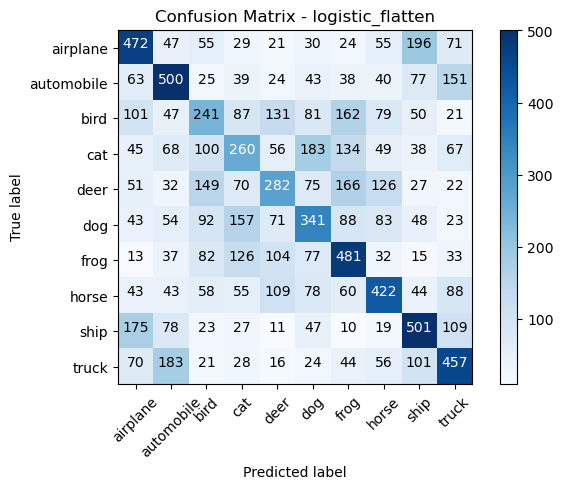

Model: random_forest_flatten
Accuracy: 0.4739
Confusion matrix, without normalization
[[570  48  37  24  36  15  30  27 153  60]
 [ 38 602  19  32  14  20  21  30  75 149]
 [108  43 297  74 155  65 137  48  47  26]
 [ 56  56  62 243  58 191 150  65  33  86]
 [ 61  18 113  61 420  33 150  84  29  31]
 [ 22  32  64 146  62 396 115  85  38  40]
 [ 13  20  77  44 112  52 601  25  23  33]
 [ 42  42  31  58  92  85  56 452  38 104]
 [101  79  10  19  16  37  19  12 631  76]
 [ 38 182  11  35  12  27  38  35  95 527]]


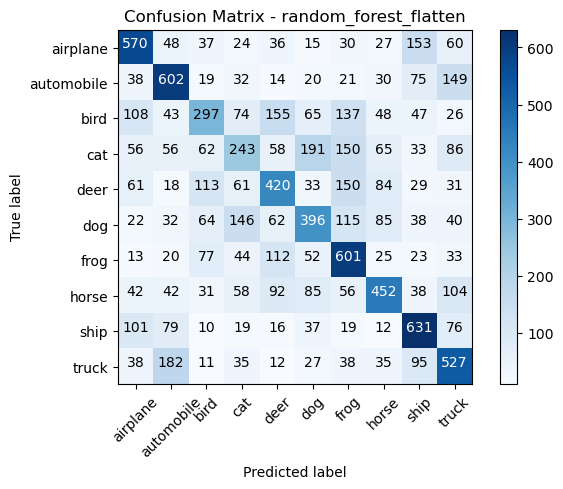

Model: random_forest_sift
Accuracy: 0.1399
Confusion matrix, without normalization
[[162  89 129  53 126  67  46 102 174  52]
 [ 27 227  86  39 140  96  52 142  66 125]
 [110  94 117  67 129  62  51 138 162  70]
 [ 35 166  60  57 104 125  74 148  96 135]
 [ 63 144  74  51 126  83  71 170 106 112]
 [ 42 189  54  69  81  98  84 146  85 152]
 [ 41 143  60  80 104  90  55 192  96 139]
 [ 28 142  66  52 108 127  56 211  51 159]
 [108 144  96  60 131  56  65  84 198  58]
 [ 31 197  51  49 108 116  55 191  54 148]]


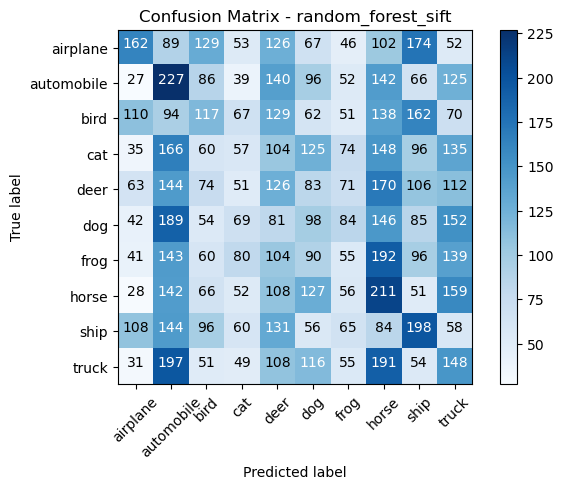

Model: random_forest_hog
Accuracy: 0.5065
Confusion matrix, without normalization
[[598  42  78  14  41  20  29  15 146  17]
 [ 31 643   8  16  16  13  67  22 103  81]
 [ 77  31 360  53 100 148 125  46  39  21]
 [ 39  44  63 249 103 210 141  72  16  63]
 [ 46  51  66  46 357  82 158 110  34  50]
 [ 10  20  73 114  82 456 101 100   9  35]
 [ 23  51  52  34  56  71 663  23  12  15]
 [ 28  28  47  43  94 119  33 534  19  55]
 [120 104  26  14  17  12  22   9 607  69]
 [ 38 125  12  28  31  28  20  40  80 598]]


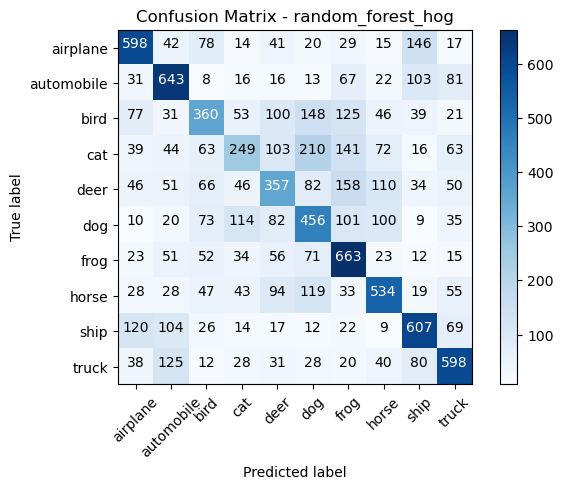

Model: svm_hog
Accuracy: 0.6292
Confusion matrix, without normalization
[[712  21  60  22  30  13  15   7 100  20]
 [ 29 782   7  15  18   6  14   5  52  72]
 [ 82  12 527  75  94  79  63  29  28  11]
 [ 50  19  96 423  85 170  77  39  13  28]
 [ 38  17  92  86 565  57  57  57   9  22]
 [ 16   6  88 175  69 502  52  67  11  14]
 [ 23  19  45  64  60  43 707  12  17  10]
 [ 22   9  56  67  71  61  12 669  11  22]
 [112  70  25  18  10  10   9  12 684  50]
 [ 26  82  12  40  19  14   7  21  58 721]]


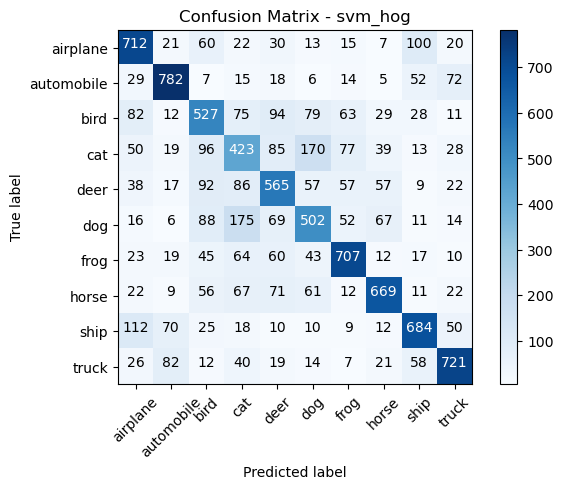

In [30]:
# Visualiser les matrices de confusion et les courbes ROC pour chaque modèle
for model_name, (y_pred, y_score) in predictions.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {np.mean(y_pred == y_test)}")
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, classes=LABEL_NAMES, title=f'Confusion Matrix - {model_name}')
    #plot_roc_curve(y_test, y_score, n_classes=NUM_CLASSES)

In [31]:
# # Visualiser les matrices de confusion et les courbes ROC pour chaque modèle
# for model_name, (y_pred, y_score) in predictions.items():
#     print(f"Model: {model_name}")
#     print(f"Accuracy: {np.mean(y_pred == y_test)}")
#     cm = confusion_matrix(y_val, y_pred)
#     plot_confusion_matrix(cm, classes=LABEL_NAMES, title=f'Confusion Matrix - {model_name}')
#     plot_roc_curve(y_val, y_score, n_classes=NUM_CLASSES)

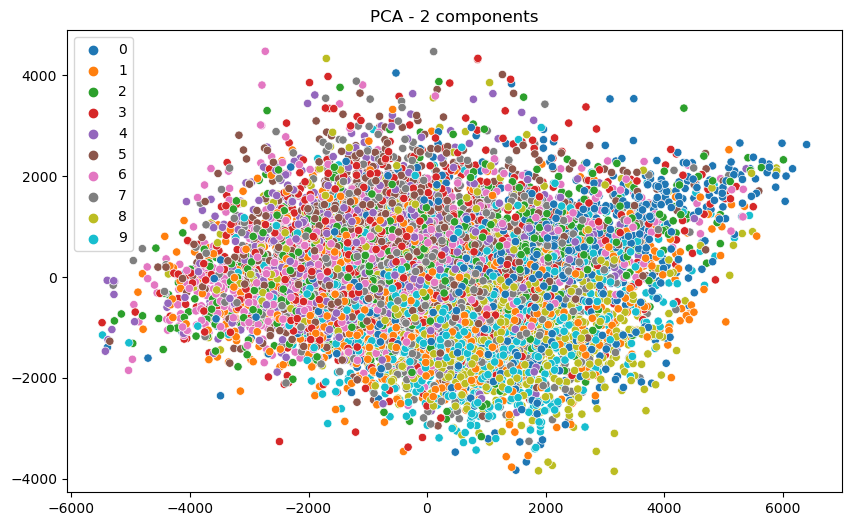

In [32]:
# visualization de l'espace latent
from sklearn.decomposition import PCA

X_test_flatten = extract_features(X_test, method='flatten')
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test_flatten)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_test_pca[:, 0], y=X_test_pca[:, 1], hue=y_test, palette='tab10')
plt.title('PCA - 2 components')
plt.show()

In [33]:
# # visualization de l'espace latent
# from sklearn.decomposition import PCA

# X_val_flatten = extract_features(X_val, method='flatten')
# pca = PCA(n_components=2)
# X_val_pca = pca.fit_transform(X_val_flatten)
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x=X_val_pca[:, 0], y=X_val_pca[:, 1], hue=y_test, palette='tab10')
# plt.title('PCA - 2 components')
# plt.show()

In [34]:
# # visualization de l'espace latent
# from sklearn.decomposition import PCA

# X_val_flatten = extract_features(X_val, method='flatten')
# pca = PCA(n_components=2)
# X_val_pca = pca.fit_transform(X_val_flatten)
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x=X_val_pca[:, 0], y=X_val_pca[:, 1], hue=y_val, palette='tab10')
# plt.title('PCA - 2 components')
# plt.show()
